# 2.3 Structured Data - Analysing

This notebook demonstrates various ways of analysing data with SparkSQL DataFrames.

We will analyse the `Air Temperature` data set from BOM,  which contains historial maximum daily temperatures from multiple weather stations in New South Wales going back to the 19th century. 

Let's have look at the data first (`data/nsw_temp.csv` file):

In [1]:
%%sh 

head -n 5 data/nsw_temp.csv

Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
IDCJAC0010,061087,1965,01,01,25.6,,Y
IDCJAC0010,061087,1965,01,02,32.2,1,Y
IDCJAC0010,061087,1965,01,03,23.1,1,Y
IDCJAC0010,061087,1965,01,04,25.6,1,Y


In [2]:
#setup display options for local mode notebooks
import pandas as pd
pd.set_option('display.max_rows', 5)

# load the 
badBomDF = spark.read.csv('data/nsw_temp.csv', inferSchema='True', header=True)

In [3]:
badBomDF.printSchema()

root
 |-- Product code: string (nullable = true)
 |-- Bureau of Meteorology station number: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Maximum temperature (Degree C): double (nullable = true)
 |-- Days of accumulation of maximum temperature: integer (nullable = true)
 |-- Quality: string (nullable = true)



In [4]:
# will fail because the file is corrupted
# badBomDF.groupBy().avg('Maximum temperature (Degree C)')

As mentioned in the previous section this file is actually corrupted as it has multiple header lines embedde in the data. 

We can clean it up by filtering out all the header lines. 

In [5]:
%%sh

# remove the condioned file if exists
rm -rf 'output/nsw_temp_ok.csv'

In [6]:
# select only the data lines (starting with IDC) and save the correct file to `output/nsw_temp_ok.csv`
sc.textFile('data/nsw_temp.csv').filter(lambda l:l.startswith('IDC')).saveAsTextFile('output/nsw_temp_ok.csv')

In [7]:
# create a DataFrame with customised column names from an RDD
bomDF = spark.createDataFrame(spark.read.csv('output/nsw_temp_ok.csv', inferSchema='True', header=False).rdd, 
        schema = ['product_id', 'station_id', 'year', 'month', 'day', 'max_temp', 'days_of_acc', 'quality'])

# cache the DataFrame for performance
bomDF.cache()
bomDF.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- station_id: long (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)
 |-- max_temp: double (nullable = true)
 |-- days_of_acc: long (nullable = true)
 |-- quality: string (nullable = true)



### Basic queries


In [8]:
# select the average `max_temp` (from all data)
bomDF.groupBy().avg('max_temp')

,avg(max_temp)
0,22.812952


In [9]:
# count the number of different 'year' values (in all data)
bomDF.select('year').distinct().count()

155

In [10]:
# select the number of observations for each year
bomDF.groupBy('year').count().sort('year')

,year,count
0,1859,365
1,1860,366
...,...,...
153,2012,7686
154,2013,4646


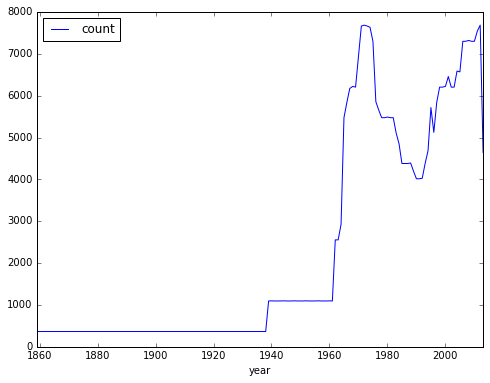

In [11]:
# visualise the number of observations per year

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.close()
bomDF.groupBy('year').count().sort('year').toPandas().set_index('year').plot()
display()

In [12]:
# find the station with most observations
from pyspark.sql.functions import *
bomDF.groupBy('station_id').count().sort(desc('count')).limit(1)

,station_id,count
0,66062,56470


In [13]:
# find the yearly average and standard deviation of `max_temp` for station `66062`
bomDF.where(col('station_id') == 66062).groupBy('year') \
    .agg(avg('max_temp').alias('avg_max_temp'), stddev('max_temp').alias('sd_max_temp')).sort('year')

,year,avg_max_temp,sd_max_temp
0,1859,21.399452,4.969578
1,1860,20.276986,4.398397
...,...,...,...
153,2012,22.669126,4.107855
154,2013,23.114414,4.502314


In [14]:
# ind the monthly average and standard deviation of `max_temp` for all station 
# in the years between 1990 and 2001
tempByStationAndMonth = bomDF.where((col('year') > 1990) &  (col('year')< 2001)) \
    .groupBy(col('station_id'), col('month')) \
    .agg(avg('max_temp').alias('avg_max_temp'), stddev('max_temp').alias('sd_max_temp')) \
    .sort(col('station_id'), col('month'))
tempByStationAndMonth

,station_id,month,avg_max_temp,sd_max_temp
0,61087,1,27.644565,4.273773
1,61087,2,28.143529,3.948642
...,...,...,...,...
238,68192,11,25.009268,4.583716
239,68192,12,27.904545,4.757572


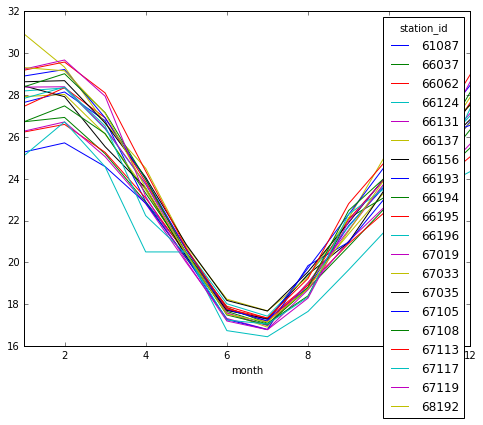

In [15]:
# visualise the average monthly `max_temp` per station
import pandas as pd
tempByStationAndMonthPD = tempByStationAndMonth.toPandas()
plt.close()
tempByStationAndMonthPD.set_index(['month', 'station_id']).unstack()['avg_max_temp'].plot()
display()

### User Defined Functions (UDFs)

In [16]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

# define a UDF uncertanity 
uncertanity = udf(lambda temp, quality: temp * (0.1 if quality == 'Y' else 0.3) if temp is not None else None 
                  , DoubleType())

In [17]:
# apply the UDF uncertanity
bomDF.select(uncertanity(col('max_temp'), col('quality')).alias('uncertanity'))

,uncertanity
0,2.56
1,3.22
...,...
352694,5.58
352695,6.78


### Window functions

Window functions allow users of Spark SQL to calculate results such as the rank of a given row or a moving average over a range of input row. For more information on Window functions please see:  [Introduction to Window Functions](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html)

In [18]:
# extend the bom DataFrame with the `date` column
bomWithDateDF = bomDF.withColumn('date', 
                                 to_date(format_string("%04d-%02d-%02d", col('year'), col('month'), col('day'))))        

In [19]:
from pyspark.sql import Window

# rank the stations each day in year 2000 based on the `max_temp` 
# (the stations with higher temperatures are ranked higher)

bomRankDF = bomWithDateDF.dropna().select(col('date'), col('station_id'), col('max_temp'),  rank() \
            .over(Window.partitionBy(col('date')).orderBy(desc('max_temp')) \
                     .rowsBetween(Window.unboundedPreceding, Window.currentRow)).alias('rank')) \
    .where(col('year')==2000).sort('date', 'rank', 'station_id')

display(bomRankDF.limit(10))

,date,station_id,max_temp,rank
0,2000-01-01,67113,23.4,1
1,2000-01-01,68192,23.0,2
...,...,...,...,...
8,2000-01-01,66137,21.8,9
9,2000-01-01,66194,21.5,10


In [20]:
# find the number of days in the year 2000 when each station was the `hottest` one
hotestStationDF = bomRankDF.where(col('rank') == 1).groupBy('station_id').count().sort(desc('count'))
display(hotestStationDF)

,station_id,count
0,67113,149
1,61087,43
...,...,...
13,67117,5
14,66137,4


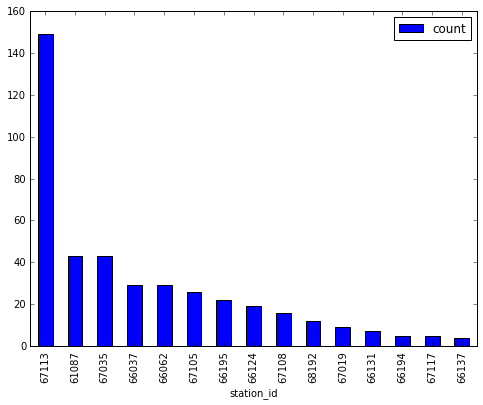

In [21]:
plt.close()
hotestStationDF.toPandas().set_index('station_id').plot(kind='bar')
display()

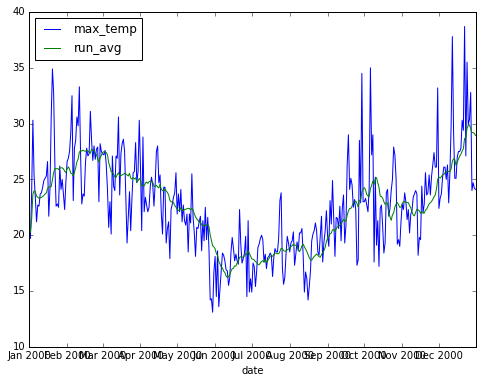

In [22]:
# use Window functions to calculate 14 days moving average for station `66062` in the year `2000`
from pyspark.sql import Window
plt.close()
bomWithDateDF.where((col('station_id') == 66062) & (col('year') == 2000)) \
             .select(col('date'), col('max_temp'), avg(col('max_temp')) \
             .over(Window.orderBy(col('date')) \
                   .partitionBy(col('station_id')).rowsBetween(-14,Window.currentRow )).alias('run_avg')).sort('date')\
    .toPandas().set_index('date').plot()
display()

### SQL

SparkSQL DataFrames can be also queries with SQL (Structured Query Language), commonly used in to query relational databases.

In [23]:
# register the DataFrame as a table named `bom`
bomDF.registerTempTable('bom')

In [24]:
# run a simple query that counts number of rows in table `bom`
display(sql('SELECT COUNT(*) FROM bom'))

,count(1)
0,352696


In [25]:
# run a query that computes the average monthly `max_temp` for all stations 
# in years after 2000.

display(sql('''SELECT station_id, month, avg(max_temp) AS avg_max_temperature FROM bom
        WHERE year > 2000 GROUP by station_id, month ORDER BY station_id, month
    '''))

,station_id,month,avg_max_temperature
0,61087,1,28.214653
1,61087,2,27.224859
...,...,...,...
279,68257,11,26.891878
280,68257,12,27.208019


In the Databricks Platform the SQL queries can be entered direclty in %sql cells.

In [26]:
#%sql
#SELECT station_id, month, avg(max_temp) AS avg_max_temperature FROM bom
#        WHERE year > 2000 GROUP by station_id, month ORDER BY station_id, month